In [5]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.stats import mode
import seaborn as sns
from collections import defaultdict
import copy 
import matplotlib.animation as animation
import math
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error

# Suppress ConvergenceWarning

In [2]:
# Functions
def distributionOfData(data):
    # Define bins
    bin_edges = np.arange(0, 11, 1)  # Bin edges at integer intervals (-4 to 4)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    # Create the histogram
    plt.hist(data, bins=bin_edges, color='blue', edgecolor='black', alpha=0.7, label="Data Distribution")

    # Add labels and title
    plt.xlabel('Value Ranges (Standard Deviations)', fontsize=12)
    plt.ylabel('Frequency (Count of Data Points)', fontsize=12)
    plt.title('Histogram of Randomly Generated Data', fontsize=14)

    # Set x-axis ticks at bin centers
    plt.xticks(bin_centers, labels=[f"{x}" for x in bin_edges[:-1]])

    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

def showDigitsData(X_data, y_data):
    # Print data
    print("Example of Data:")

    plt.imshow(X_data[0].reshape(8, 8), cmap="gray")
    plt.title(f"Example Image (Label: {y_data[0]})")
    plt.show()

def showNumericalDigitsData(digits):
    for i in range(3):
        print(f"Y-value: {digits.target[i]}")
        print(f"X-Value: {digits.data[i]}\n")

def filteredDigits():
        # Load the digits dataset
    digits = load_digits()

    # Extract the labels (target) from the dataset
    y = digits.target

    # Use np.where to find the indices of labels that are less than 5
    indices_less_than_5 = np.where(y < 5)
    
    return digits.data[indices_less_than_5], digits.target[indices_less_than_5], 

def allDigits():
    digits = load_digits()
    return digits.data, digits.target

In [ ]:
def unsupervisedModel():
    

In [7]:
X_data, y_data = filteredDigits()
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_test, y_test = allDigits()
print(f"Length of training data: {len(X_train)}")
print(f"Length of testing data: {len(X_test)}")

Length of training data: 720
Length of testing data: 1797


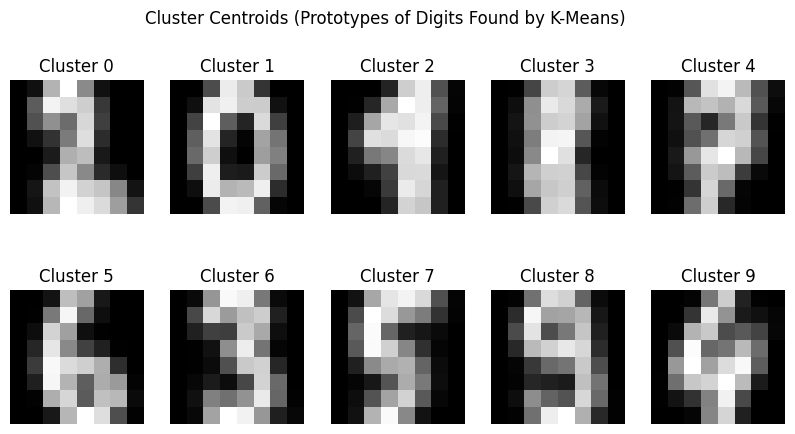

Cluster Mapping (K-Means Cluster → True Digit): {0: np.int64(2), 1: np.int64(0), 2: np.int64(1), 3: np.int64(8), 4: np.int64(7), 5: np.int64(6), 6: np.int64(3), 7: np.int64(5), 8: np.int64(9), 9: np.int64(4)}


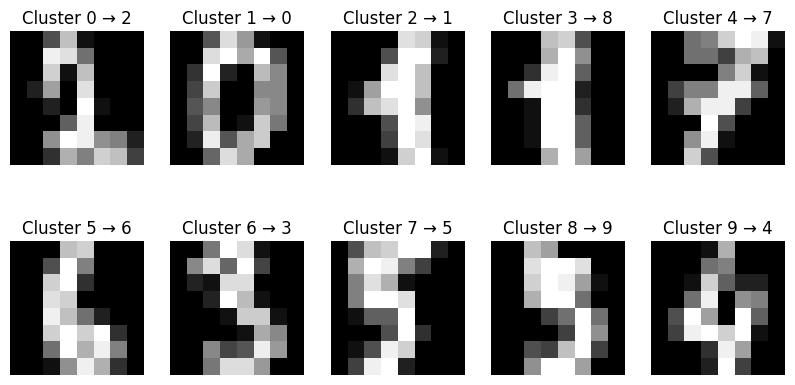

In [9]:
X, y_true = allDigits()
model = KMeans(n_clusters=10, random_state=42, n_init=10)
cluster_labels = model.fit_predict(X)
centroids = model.cluster_centers_.reshape(10, 8, 8)
# Plot cluster centroids as images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(centroids[i], cmap="gray")
    ax.set_title(f"Cluster {i}")
    ax.axis("off")

plt.suptitle("Cluster Centroids (Prototypes of Digits Found by K-Means)")
plt.show()

# Map each cluster to the most common true label
cluster_map = {}
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) > 0:  # Ensure there are samples in this cluster
        most_common_label = mode(y_true[cluster_indices], keepdims=True).mode[0]
        cluster_map[cluster] = most_common_label

print(f"Cluster Mapping (K-Means Cluster → True Digit): {cluster_map}")

# Show examples from each cluster with mapped labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) > 0:  # Ensure the cluster is not empty
        sample_idx = cluster_indices[0]  # Select first image in the cluster
        ax = axes[cluster // 5, cluster % 5]
        ax.imshow(X[sample_idx].reshape(8, 8), cmap='gray')
        ax.set_title(f"Cluster {cluster} → {cluster_map[cluster]}")
        ax.axis('off')
plt.show()

In [ ]:
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    print(cluster_indices)
    cluster_map

    if len(cluster_indices) > 0:  # Ensure the cluster is not empty
        sample_idx = cluster_indices[0]  # Select first image in the cluster
        ax = axes[cluster // 5, cluster % 5]
        ax.imshow(X[sample_idx].reshape(8, 8), cmap='gray')
        ax.set_title(f"Cluster {cluster} → {cluster_map[cluster]}")
        ax.axis('off')
plt.show()

[   7   27   43   44   52   86  108  173  174  222  231  263  283  300
  308  317  325  374  375  381  384  393  403  413  429  430  438  447
  467  472  480  494  498  504  543  559  560  577  602  634  653  655
  663  665  673  675  677  683  685  689  690  698  707  715  719  727
  732  738  740  751  754  757  758  765  770  771  774  820  862  891
  912  932  949  963  983  995 1009 1022 1043 1095 1118 1135 1174 1184
 1269 1275 1304 1399 1422 1432 1442 1458 1467 1468 1476 1496 1509 1523
 1527 1533 1542 1562 1572 1574 1612 1633 1674 1684 1710 1711 1712 1761
 1779]
[  15   25   32   33   35   46   71   74  102  109  117  120  135  145
  155  162  163  165  176  201  204  230  237  245  246  265  271  281
  288  289  302  327  330  348  361  365  373  376  391  401  411  418
  419  432  460  488  495  503  506  521  531  541  548  562  587  590
  625  633  636  651  661  671  679  681  692  717  720  748  755  763
  766  779  781  791  801  808  809  811  822  847  850  878  885  893

In [59]:
print(cluster_map[2])

1


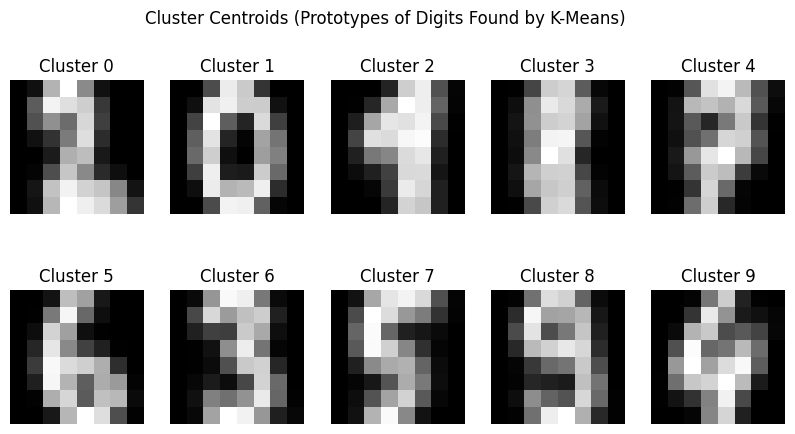

Cluster Mapping (K-Means Cluster → True Digit): {0: np.int64(2), 1: np.int64(0), 2: np.int64(1), 3: np.int64(8), 4: np.int64(7), 5: np.int64(6), 6: np.int64(3), 7: np.int64(5), 8: np.int64(9), 9: np.int64(4)}


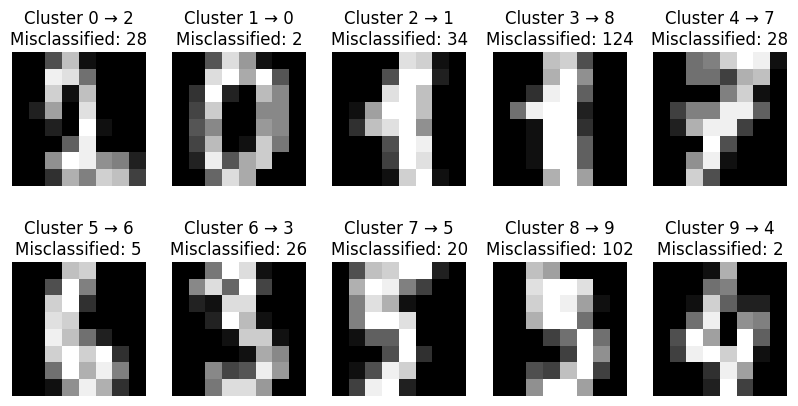

Misclassified and Total Images per Cluster:
Cluster 0: 28 misclassified images out of 176 total images (16%)
Cluster 1: 2 misclassified images out of 179 total images (1%)
Cluster 2: 34 misclassified images out of 89 total images (38%)
Cluster 3: 124 misclassified images out of 226 total images (55%)
Cluster 4: 28 misclassified images out of 198 total images (14%)
Cluster 5: 5 misclassified images out of 182 total images (3%)
Cluster 6: 26 misclassified images out of 181 total images (14%)
Cluster 7: 20 misclassified images out of 157 total images (13%)
Cluster 8: 102 misclassified images out of 241 total images (42%)
Cluster 9: 2 misclassified images out of 168 total images (1%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.cluster import KMeans

X, y_true = allDigits()

# Fit KMeans model
model = KMeans(n_clusters=10, random_state=42, n_init=10)
cluster_labels = model.fit_predict(X)

# Get cluster centroids
centroids = model.cluster_centers_.reshape(10, 8, 8)

# Plot cluster centroids as images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(centroids[i], cmap="gray")
    ax.set_title(f"Cluster {i}")
    ax.axis("off")

plt.suptitle("Cluster Centroids (Prototypes of Digits Found by K-Means)")
plt.show()

# Map each cluster to the most common true label
cluster_map = {}
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) > 0:  # Ensure there are samples in this cluster
        most_common_label = mode(y_true[cluster_indices], keepdims=True).mode[0]
        cluster_map[cluster] = most_common_label

print(f"Cluster Mapping (K-Means Cluster → True Digit): {cluster_map}")

# Count misclassified images per cluster
misclassified_counts = {i: 0 for i in range(10)}
totalCounts = {i: 0 for i in range(10)}

# Loop through all clusters and count misclassified samples
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) > 0:  # Ensure the cluster is not empty
        predicted_label = cluster_map[cluster]  # The most common label for this cluster
        # Compare predicted label to the true label for each sample in the cluster
        for idx in cluster_indices:
            if y_true[idx] != predicted_label:
                misclassified_counts[cluster] += 1
            totalCounts[cluster] += 1

# Show examples from each cluster with mapped labels and misclassification count
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    if len(cluster_indices) > 0:  # Ensure the cluster is not empty
        sample_idx = cluster_indices[0]  # Select first image in the cluster
        ax = axes[cluster // 5, cluster % 5]
        ax.imshow(X[sample_idx].reshape(8, 8), cmap='gray')
        ax.set_title(f"Cluster {cluster} → {cluster_map[cluster]}\nMisclassified: {misclassified_counts[cluster]}")
        ax.axis('off')
plt.show()

print("Misclassified and Total Images per Cluster:")
for cluster in misclassified_counts.keys():
    misclassified = misclassified_counts[cluster]
    total = totalCounts.get(cluster, 0)  # Default to 0 if the cluster doesn't exist in totalCounts
    print(f"Cluster {cluster}: {misclassified} misclassified images out of {total} total images ({misclassified/total * 100:.0f}%)")





Cluster 0: 28 misclassified images


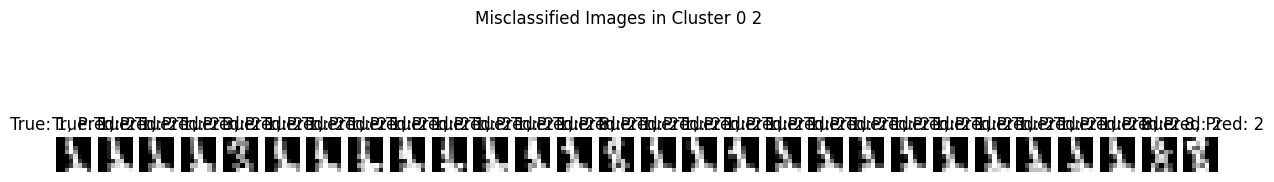

Cluster 1: 2 misclassified images


IndexError: list index out of range

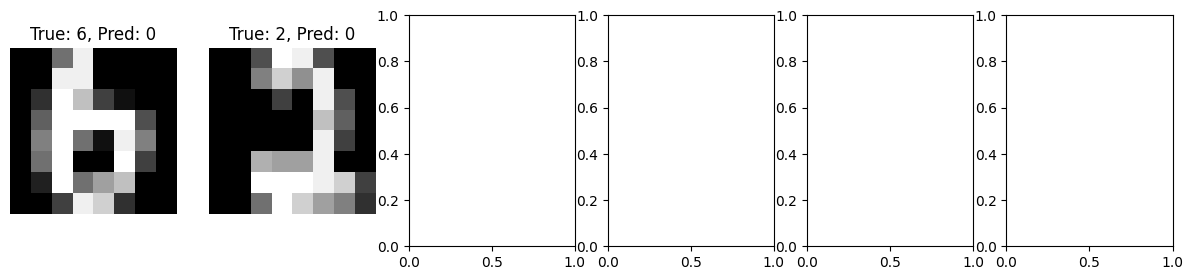

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate through each cluster and print misclassified images
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    predicted_label = cluster_map[cluster]  # Most common label for this cluster

    # Find misclassified indices in the cluster
    misclassified_indices = [idx for idx in cluster_indices if y_true[idx] != predicted_label]
    
    if misclassified_indices:
        print(f"Cluster {cluster}: {len(misclassified_indices)} misclassified images")
        
        # Plot misclassified images
        fig, axes = plt.subplots(1, min(6, len(misclassified_indices)), figsize=(15, 3))
        for i, ax in enumerate(axes):
            ax.imshow(X[misclassified_indices[i]].reshape(8, 8), cmap='gray')
            ax.axis('off')
            ax.set_title(f"True: {y_true[misclassified_indices[i]]}, Pred: {predicted_label}")
        plt.suptitle(f"Misclassified Images in Cluster {cluster} {predicted_label}")
        plt.show()


Cluster 0: 148 correctly classified images


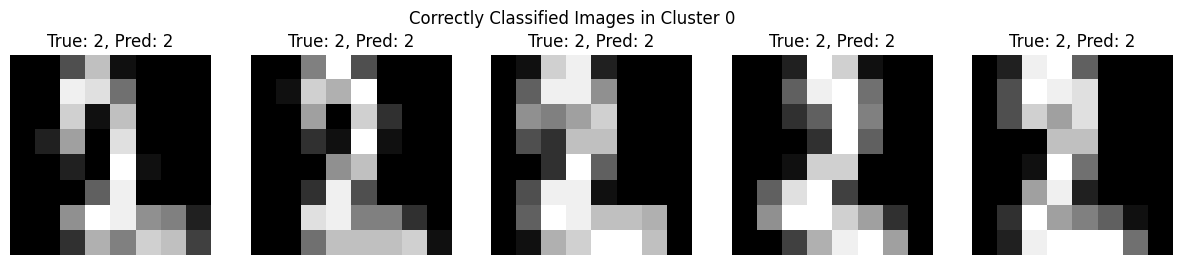

Cluster 1: 177 correctly classified images


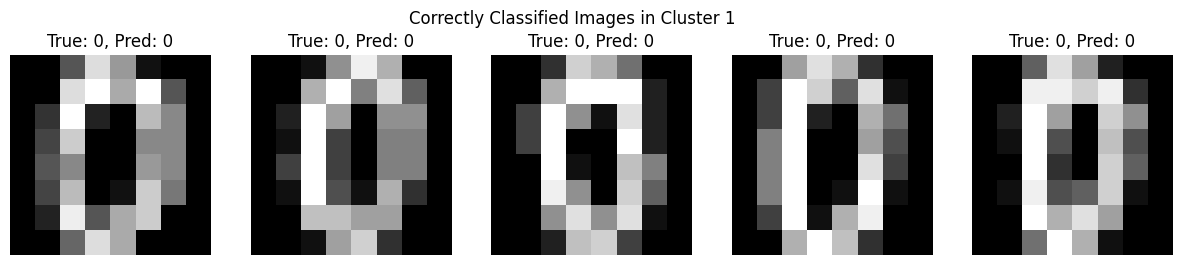

Cluster 2: 55 correctly classified images


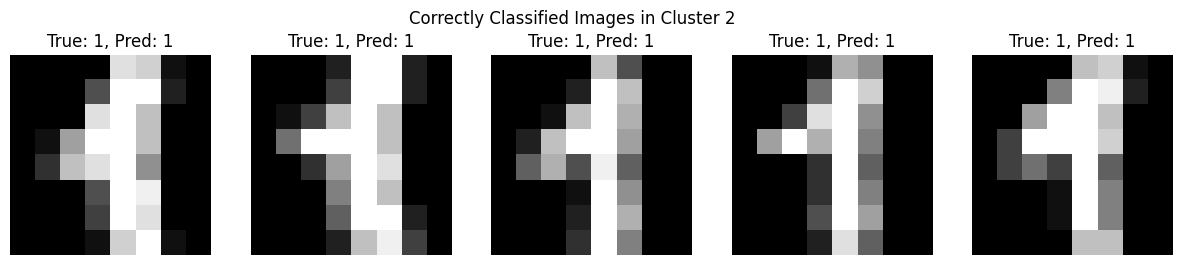

Cluster 3: 102 correctly classified images


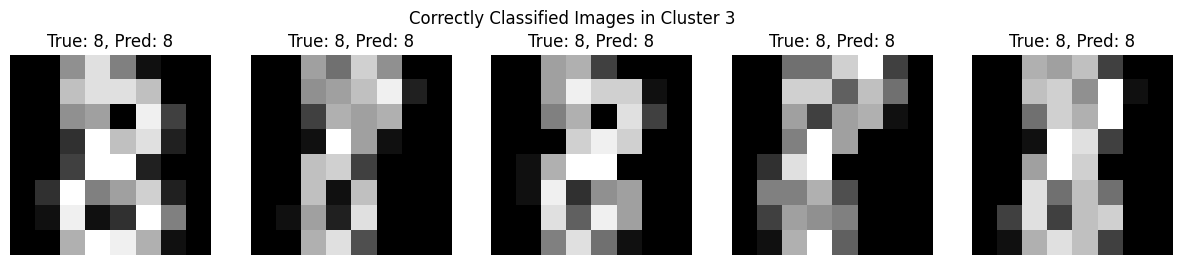

Cluster 4: 170 correctly classified images


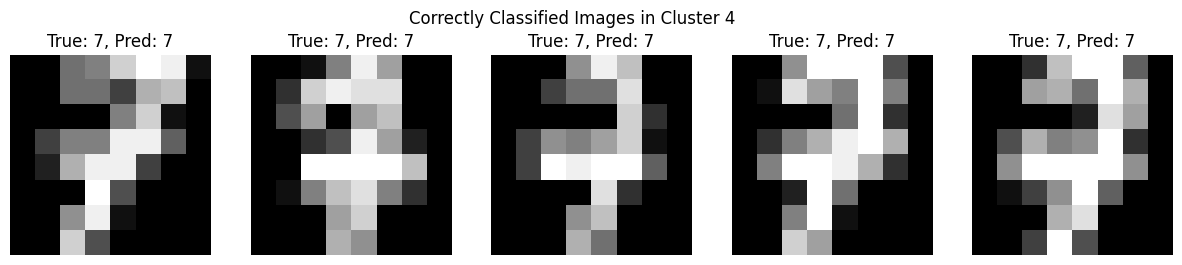

Cluster 5: 177 correctly classified images


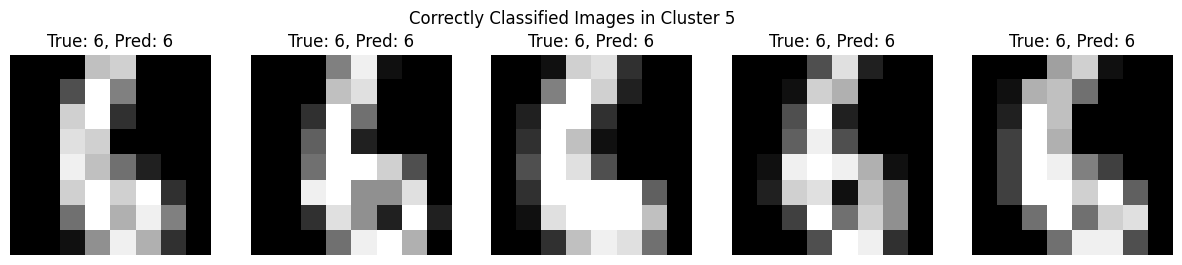

Cluster 6: 155 correctly classified images


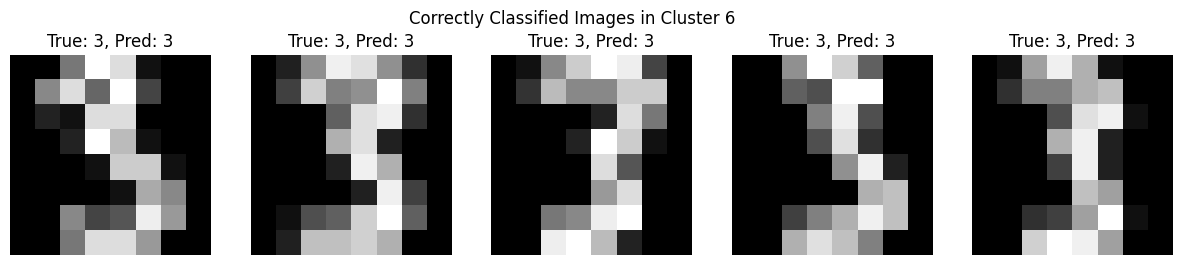

Cluster 7: 137 correctly classified images


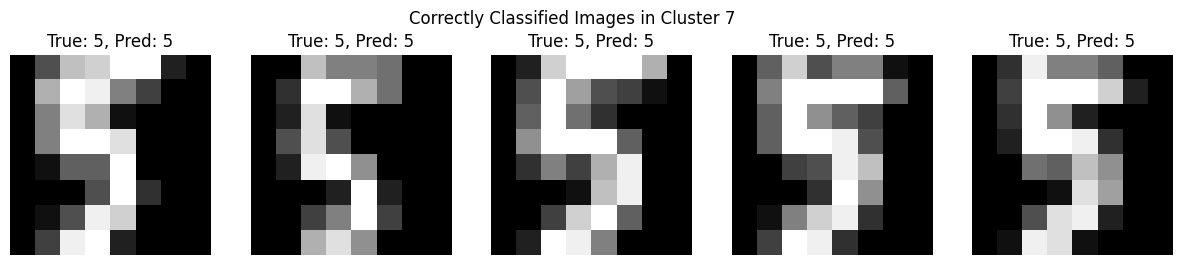

Cluster 8: 139 correctly classified images


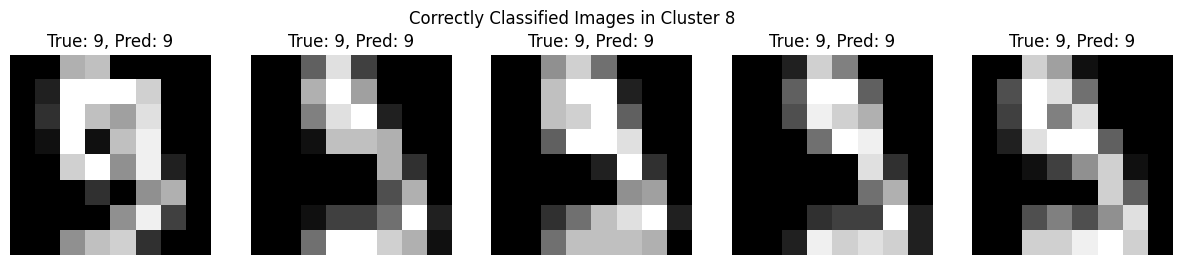

Cluster 9: 166 correctly classified images


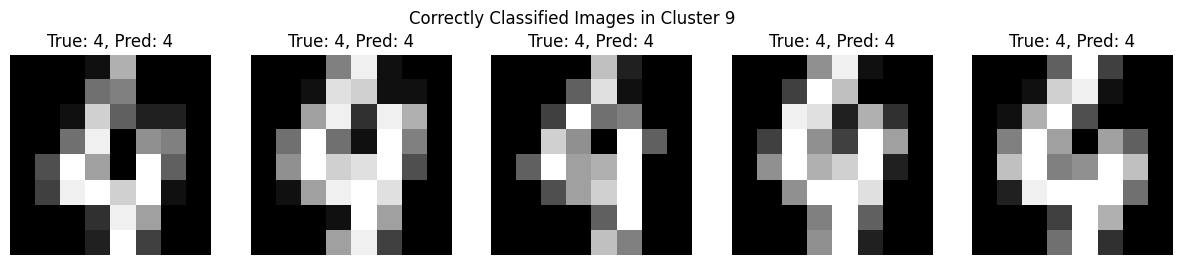

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Iterate through each cluster and print correctly classified images
for cluster in range(10):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    predicted_label = cluster_map[cluster]  # Most common label for this cluster

    # Find correctly classified indices in the cluster
    correctly_classified_indices = [idx for idx in cluster_indices if y_true[idx] == predicted_label]
    
    if correctly_classified_indices:
        print(f"Cluster {cluster}: {len(correctly_classified_indices)} correctly classified images")
        
        # Plot correctly classified images
        fig, axes = plt.subplots(1, min(5, len(correctly_classified_indices)), figsize=(15, 3))  # Limit to 5 images per cluster
        for i, ax in enumerate(axes):
            ax.imshow(X[correctly_classified_indices[i]].reshape(8, 8), cmap='gray')
            ax.axis('off')
            ax.set_title(f"True: {y_true[correctly_classified_indices[i]]}, Pred: {predicted_label}")
        plt.suptitle(f"Correctly Classified Images in Cluster {cluster}")
        plt.show()
